<a href="https://colab.research.google.com/github/tops201/project_507/blob/main/507_508/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras

#from google.colab import files #for google colab

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential

from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Dense, Input, Lambda, LSTM

In [2]:
#fetch dataset

#data_file = files.upload() #for google colab

#df = pd.read_excel(io.BytesIO(data_file["daily_field_data.xlsx"]), index_col="DATEPRD") #for google colab
df = pd.read_excel("consolidated_field_data.xlsx", index_col="DATE") #for local IDE

date = df.index

df.head()

,BORE_GAS_VOL,BORE_OIL_VOL
DATE,,
2008-02-12,38888.67,284.65
2008-02-13,285246.16,1869.70
2008-02-14,509954.88,3124.09
2008-02-15,383426.67,2608.28
2008-02-16,418474.00,3051.80


In [28]:
#function to plot a series
def plot_series(x, y, ylabel=None, format="-", start=None, end=None, label=None):
    plt.plot(x[start:end], y[start:end], format, label=label)
    plt.xlabel("Date")
    plt.ylabel(f"{ylabel} Volume")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

#clear session 
def refresh():
    keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)

class ResetStatesCallback(Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

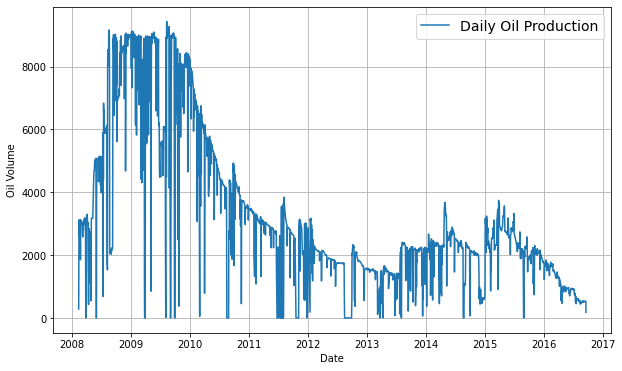

array([ 284.65, 1869.7 , 3124.09, ...,  534.87,  530.27,  180.04])

In [21]:
oil_data = df.BORE_OIL_VOL.to_numpy()

plt.figure(figsize=(10, 6))
plot_series(date, oil_data, "Oil", label="Daily Oil Production")
plt.show()

oil_data

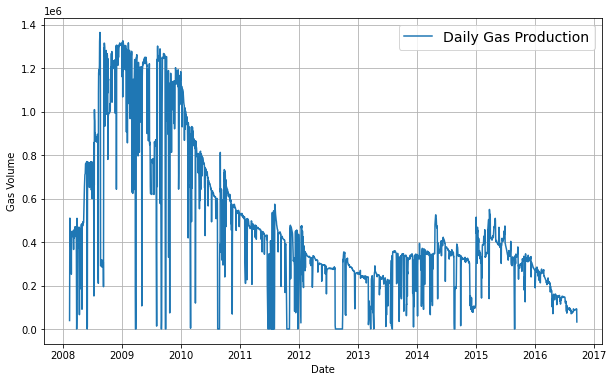

array([ 38888.67, 285246.16, 509954.88, ...,  91890.07,  91579.73,
        32165.98])

In [23]:
gas_data = df.BORE_GAS_VOL.to_numpy()

plt.figure(figsize=(10, 6))
plot_series(date, gas_data, "Gas", label="Daily Gas Production")
plt.show()

gas_data

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

scaled_df = pd.DataFrame(scaled, index=df.index, columns=df.columns)
scaled_df.head()

,BORE_GAS_VOL,BORE_OIL_VOL
DATE,,
2008-02-12,0.028509,0.030164
2008-02-13,0.209112,0.198133
2008-02-14,0.373844,0.331061
2008-02-15,0.281087,0.276400
2008-02-16,0.306780,0.323400


In [15]:
scaled_oil_data = scaled_df.BORE_OIL_VOL.to_numpy()

scaled_gas_data = scaled_df.BORE_GAS_VOL.to_numpy()

In [25]:
#split the time series into training and validation sets
split_date = 2140

date_train = date[:split_date]
date_valid = date[split_date:]

oil_train = scaled_oil_data[:split_date]
oil_valid = scaled_oil_data[split_date:]

gas_train = scaled_gas_data[:split_date]
gas_valid = scaled_gas_data[split_date:]

print(oil_train.shape, oil_valid.shape, gas_train.shape, gas_valid.shape, date_train.shape, date_valid.shape)

(2140,) (916,) (2140,) (916,) (2140,) (916,)


# NAIVE Forecast

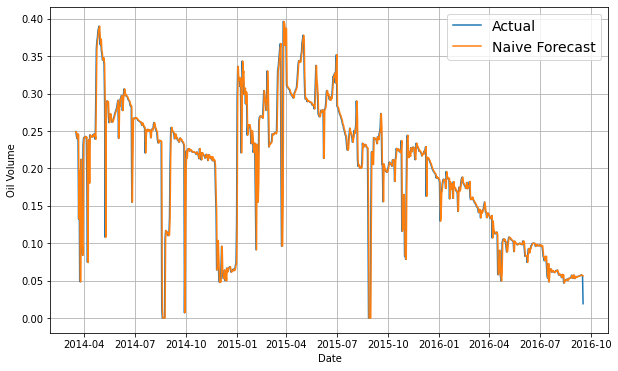

mae = 0.011220688574470455, 
mse = 0.0008306426000780921, 
rmse = 0.028820870911165957


In [31]:
naive_oil_forecast = scaled_oil_data[split_date - 1:-1]

plt.figure(figsize=(10, 6))
plot_series(date_valid, oil_valid, label="Actual")
plot_series(date_valid, naive_oil_forecast,"Oil", label="Naive Forecast")

plt.show()

mae = keras.metrics.mean_absolute_error(oil_valid, naive_oil_forecast).numpy()
mse = keras.metrics.mean_squared_error(oil_valid, naive_oil_forecast).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

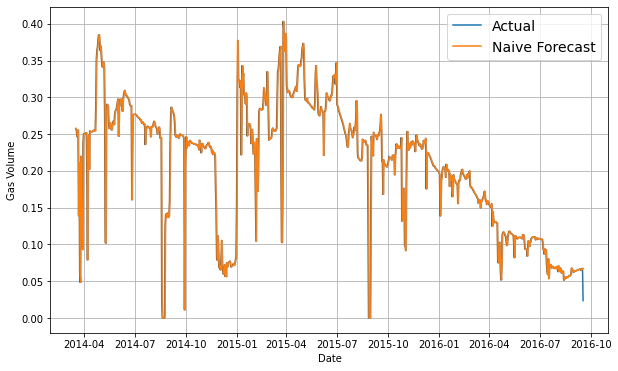

mae = 0.01133224633075155, 
mse = 0.0008716956372222274, 
rmse = 0.029524492158582973


In [32]:
naive_gas_forecast = scaled_gas_data[split_date - 1:-1]

plt.figure(figsize=(10, 6))
plot_series(date_valid, gas_valid, label="Actual")
plot_series(date_valid, naive_gas_forecast,"Gas", label="Naive Forecast")

plt.show()

mae = keras.metrics.mean_absolute_error(gas_valid, naive_gas_forecast).numpy()
mse = keras.metrics.mean_squared_error(gas_valid, naive_gas_forecast).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

# Moving Average

In [34]:
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
    If window_size=1, then this is equivalent to naive forecast"""
    
    mov = np.cumsum(series)
    mov[window_size:] = mov[window_size:] - mov[:-window_size]
    
    return mov[window_size - 1:-1] / window_size

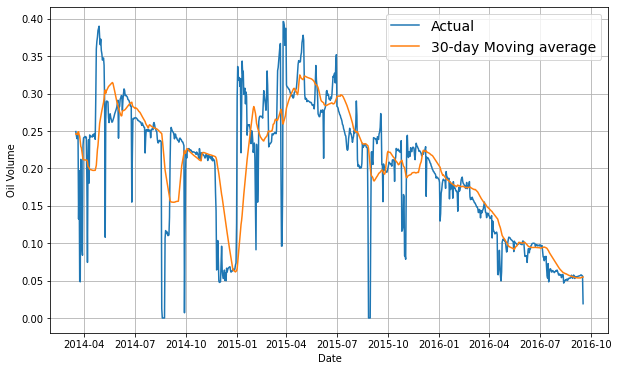

mae = 0.03273613551274348, 
mse = 0.002995516502085706, 
rmse = 0.05473131189808724


In [35]:
oil_moving_avg = moving_average_forecast(scaled_oil_data, 30)[split_date - 30:]

plt.figure(figsize=(10, 6))
plot_series(date_valid, oil_valid, label="Actual")
plot_series(date_valid, oil_moving_avg, "Oil", label="30-day Moving average")

plt.show()

mae = keras.metrics.mean_absolute_error(oil_valid, oil_moving_avg).numpy()
mse = keras.metrics.mean_squared_error(oil_valid, oil_moving_avg).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

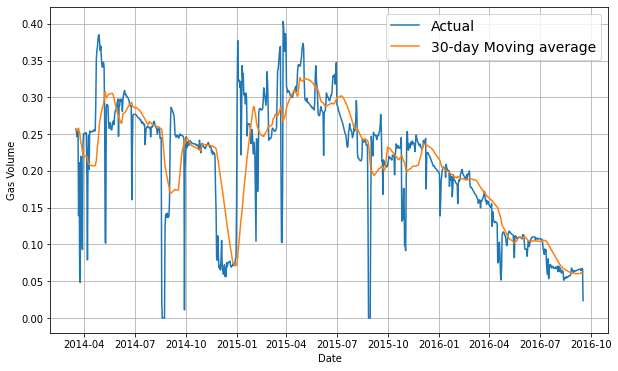

mae = 0.032397228580513214, 
mse = 0.0029799831644729074, 
rmse = 0.0545892220541098


In [36]:
gas_moving_avg = moving_average_forecast(scaled_gas_data, 30)[split_date - 30:]

plt.figure(figsize=(10, 6))
plot_series(date_valid, gas_valid, label="Actual")
plot_series(date_valid, gas_moving_avg, "Gas", label="30-day Moving average")

plt.show()

mae = keras.metrics.mean_absolute_error(gas_valid, gas_moving_avg).numpy()
mse = keras.metrics.mean_squared_error(gas_valid, gas_moving_avg).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

# Linear Model

Oil

In [37]:
def window_dataset(series, window_size, batch_size=30, shuffle_buffer=100):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(2)
    
    return dataset


def model_forecast(model, series, window_size):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(30).prefetch(2)
    
    forecast = model.predict(dataset)
    
    return forecast

In [38]:
refresh()

window_size = 30

oil_train_set = window_dataset(oil_train, window_size)

model = Sequential( [ Dense(1, input_shape=[window_size]) ] )

lr_schedule = LearningRateScheduler(
                lambda epoch: 1e-4 * 10**(epoch / 30)
                )

optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(oil_train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
71/71 [==============================] - 6s 21ms/step - loss: 0.2671 - mae: 0.5835
Epoch 2/100
71/71 [==============================] - 0s 5ms/step - loss: 0.1087 - mae: 0.3373
Epoch 3/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0408 - mae: 0.1940
Epoch 4/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0221 - mae: 0.1379
Epoch 5/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0175 - mae: 0.1212
Epoch 6/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0164 - mae: 0.1175
Epoch 7/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0161 - mae: 0.1164
Epoch 8/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0159 - mae: 0.1155
Epoch 9/100
71/71 [==============================] - ETA: 0s - loss: 0.0165 - mae: 0.117 - 0s 5ms/step - loss: 0.0158 - mae: 0.1147
Epoch 10/100
71/71 [==============================] - 0s 6ms/step - loss: 0.0156 - mae: 0.1137
Epoch 11/100
71/71 [

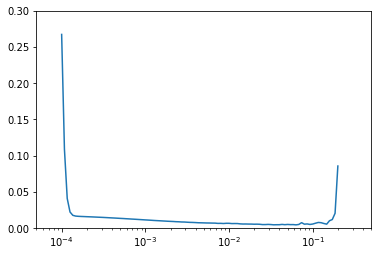

0.2670508921146393

In [39]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([5e-5, 5e-1, 0, 0.3])

plt.show()

max(history.history["loss"])

In [42]:
keras.backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

oil_train_set = window_dataset(oil_train, window_size)
oil_valid_set = window_dataset(oil_valid, window_size)

model = Sequential( [ Dense(1, input_shape=[window_size]) ] )

optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = EarlyStopping(patience=10)

model.fit(
    
    oil_train_set,
    epochs=500,
    validation_data=oil_valid_set,
    callbacks=[early_stopping]

)


Epoch 1/500
71/71 [==============================] - 2s 15ms/step - loss: 0.1622 - mae: 0.4030 - val_loss: 0.0068 - val_mae: 0.0977
Epoch 2/500
71/71 [==============================] - 1s 7ms/step - loss: 0.0280 - mae: 0.1402 - val_loss: 0.0034 - val_mae: 0.0561
Epoch 3/500
71/71 [==============================] - ETA: 0s - loss: 0.0296 - mae: 0.148 - 1s 7ms/step - loss: 0.0270 - mae: 0.1411 - val_loss: 0.0033 - val_mae: 0.0554
Epoch 4/500
71/71 [==============================] - 1s 8ms/step - loss: 0.0257 - mae: 0.1361 - val_loss: 0.0031 - val_mae: 0.0523
Epoch 5/500
71/71 [==============================] - 1s 9ms/step - loss: 0.0246 - mae: 0.1333 - val_loss: 0.0030 - val_mae: 0.0514
Epoch 6/500
71/71 [==============================] - 1s 8ms/step - loss: 0.0236 - mae: 0.1294 - val_loss: 0.0028 - val_mae: 0.0495
Epoch 7/500
71/71 [==============================] - 1s 8ms/step - loss: 0.0227 - mae: 0.1264 - val_loss: 0.0027 - val_mae: 0.0479
Epoch 8/500
71/71 [=========================

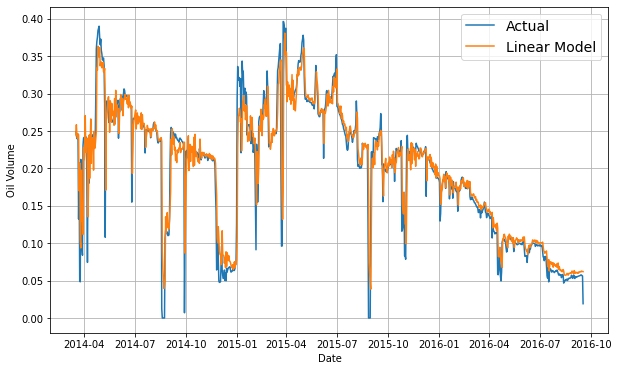

mae = 0.01636890321969986, 
mse = 0.0009179107728414237, 
rmse = 0.030297042311773995


In [48]:
linear_oil_forecast = model_forecast(model, scaled_oil_data[split_date - window_size:-1], window_size)[:, 0]

plt.figure(figsize=(10, 6))
plot_series(date_valid, oil_valid, label="Actual")
plot_series(date_valid, linear_oil_forecast, "Oil", label="Linear Model")

plt.show()

mae = keras.metrics.mean_absolute_error(oil_valid, linear_oil_forecast).numpy()
mse = keras.metrics.mean_squared_error(oil_valid, linear_oil_forecast).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

In [50]:
#model.summary()
#print(model.trainable_variables)

Gas

In [51]:
refresh()

window_size = 30

gas_train_set = window_dataset(gas_train, window_size)

model = Sequential( [ Dense(1, input_shape=[window_size]) ] )

lr_schedule = LearningRateScheduler(
                lambda epoch: 1e-4 * 10**(epoch / 30)
                )

optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(gas_train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
71/71 [==============================] - 1s 6ms/step - loss: 0.2635 - mae: 0.5876
Epoch 2/100
71/71 [==============================] - 0s 5ms/step - loss: 0.1063 - mae: 0.3401
Epoch 3/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0403 - mae: 0.1958
Epoch 4/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0219 - mae: 0.1386A: 0s - loss: 0.0523 - mae: 0
Epoch 5/100
71/71 [==============================] - 0s 4ms/step - loss: 0.0173 - mae: 0.1213
Epoch 6/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0162 - mae: 0.1174
Epoch 7/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0159 - mae: 0.1163
Epoch 8/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0157 - mae: 0.1155
Epoch 9/100
71/71 [==============================] - 0s 4ms/step - loss: 0.0155 - mae: 0.1147A: 0s - loss: 0.0310 - mae: 0.
Epoch 10/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0154 - mae: 0.1138


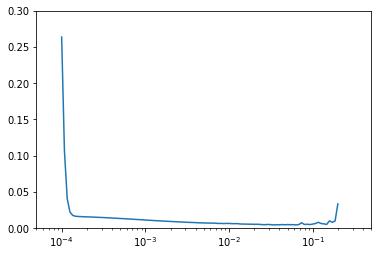

0.2634711265563965

In [52]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([5e-5, 5e-1, 0, 0.3])

plt.show()

max(history.history["loss"])

In [84]:
keras.backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

gas_train_set = window_dataset(gas_train, window_size)
gas_valid_set = window_dataset(gas_valid, window_size)

model = Sequential( [ Dense(1, input_shape=[window_size]) ] )

optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = EarlyStopping(patience=10)

model.fit(
    
    gas_train_set,
    epochs=500,
    validation_data=gas_valid_set,
    callbacks=[early_stopping]

)


Epoch 1/500
71/71 [==============================] - 2s 13ms/step - loss: 0.1593 - mae: 0.3992 - val_loss: 0.0064 - val_mae: 0.0925
Epoch 2/500
71/71 [==============================] - 1s 9ms/step - loss: 0.0275 - mae: 0.1402 - val_loss: 0.0035 - val_mae: 0.0561
Epoch 3/500
71/71 [==============================] - 1s 9ms/step - loss: 0.0267 - mae: 0.1416 - val_loss: 0.0034 - val_mae: 0.0552
Epoch 4/500
71/71 [==============================] - 1s 9ms/step - loss: 0.0254 - mae: 0.1370 - val_loss: 0.0032 - val_mae: 0.0525
Epoch 5/500
71/71 [==============================] - 1s 11ms/step - loss: 0.0243 - mae: 0.1341 - val_loss: 0.0031 - val_mae: 0.0515
Epoch 6/500
71/71 [==============================] - 1s 9ms/step - loss: 0.0233 - mae: 0.1303 - val_loss: 0.0029 - val_mae: 0.0497
Epoch 7/500
71/71 [==============================] - 1s 8ms/step - loss: 0.0224 - mae: 0.1273 - val_loss: 0.0028 - val_mae: 0.0482
Epoch 8/500
71/71 [==============================] - 1s 7ms/step - loss: 0.0215 -

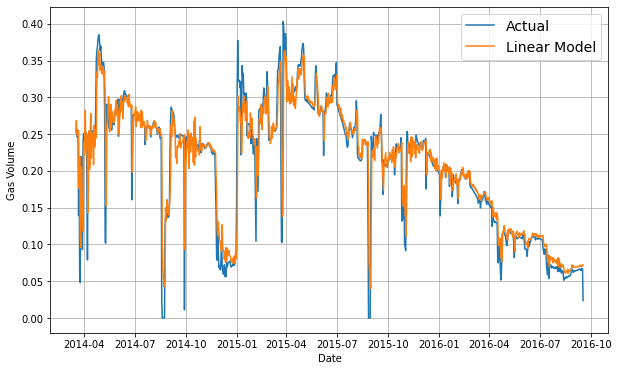

mae = 0.016262970864772797, 
mse = 0.0009474352700635791, 
rmse = 0.030780436482668323


In [85]:
linear_gas_forecast = model_forecast(model, scaled_gas_data[split_date - window_size:-1], window_size)[:, 0]

plt.figure(figsize=(10, 6))
plot_series(date_valid, gas_valid, label="Actual")
plot_series(date_valid, linear_gas_forecast, "Gas", label="Linear Model")

plt.show()

mae = keras.metrics.mean_absolute_error(gas_valid, linear_gas_forecast).numpy()
mse = keras.metrics.mean_squared_error(gas_valid, linear_gas_forecast).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

In [50]:
#model.summary()
#print(model.trainable_variables)

#  FF-NN

Oil

In [55]:
refresh()

window_size = 30

oil_train_set = window_dataset(oil_train, window_size)

model = Sequential([
            Dense(10, activation="relu", input_shape=[window_size]),
            Dense(10, activation="relu"),
            Dense(1)
        ])

lr_schedule = LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(oil_train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
71/71 [==============================] - 1s 5ms/step - loss: 0.1265 - mae: 0.4093
Epoch 2/100
71/71 [==============================] - 0s 4ms/step - loss: 0.1086 - mae: 0.3761
Epoch 3/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0913 - mae: 0.3416
Epoch 4/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0751 - mae: 0.3066
Epoch 5/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0606 - mae: 0.2720
Epoch 6/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0482 - mae: 0.2391A: 0s - loss: 0.0806 - mae: 0.3
Epoch 7/100
71/71 [==============================] - 0s 4ms/step - loss: 0.0378 - mae: 0.2082
Epoch 8/100
71/71 [==============================] - 0s 4ms/step - loss: 0.0295 - mae: 0.1800
Epoch 9/100
71/71 [==============================] - 0s 4ms/step - loss: 0.0231 - mae: 0.1548
Epoch 10/100
71/71 [==============================] - 0s 4ms/step - loss: 0.0184 - mae: 0.1340
Epoch 11/100
71/71 [========

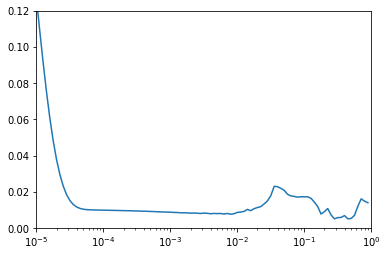

0.8912509

In [56]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1, 0, 0.12])

plt.show()

max(history.history["lr"])

In [57]:
refresh()

window_size = 30

oil_train_set = window_dataset(oil_train, window_size)
oil_valid_set = window_dataset(oil_valid, window_size)

model = Sequential([
            Dense(10, activation="relu", input_shape=[window_size]),
            Dense(10, activation="relu"),
            Dense(1)
        ])

optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = EarlyStopping(patience=10)

model.fit(oil_train_set,
          epochs=500,
          validation_data=oil_valid_set,
          callbacks=[early_stopping])

Epoch 1/500
71/71 [==============================] - 2s 16ms/step - loss: 0.0407 - mae: 0.2023 - val_loss: 0.0032 - val_mae: 0.0661
Epoch 2/500
71/71 [==============================] - 1s 8ms/step - loss: 0.0114 - mae: 0.0952 - val_loss: 0.0020 - val_mae: 0.0435
Epoch 3/500
71/71 [==============================] - 1s 8ms/step - loss: 0.0116 - mae: 0.0990 - val_loss: 0.0019 - val_mae: 0.0433
Epoch 4/500
71/71 [==============================] - 1s 9ms/step - loss: 0.0110 - mae: 0.0944 - val_loss: 0.0018 - val_mae: 0.0409
Epoch 5/500
71/71 [==============================] - 1s 8ms/step - loss: 0.0107 - mae: 0.0927 - val_loss: 0.0017 - val_mae: 0.0397
Epoch 6/500
71/71 [==============================] - 1s 8ms/step - loss: 0.0104 - mae: 0.0903 - val_loss: 0.0017 - val_mae: 0.0385
Epoch 7/500
71/71 [==============================] - 1s 7ms/step - loss: 0.0102 - mae: 0.0886 - val_loss: 0.0016 - val_mae: 0.0370
Epoch 8/500
71/71 [==============================] - 1s 7ms/step - loss: 0.0099 - 

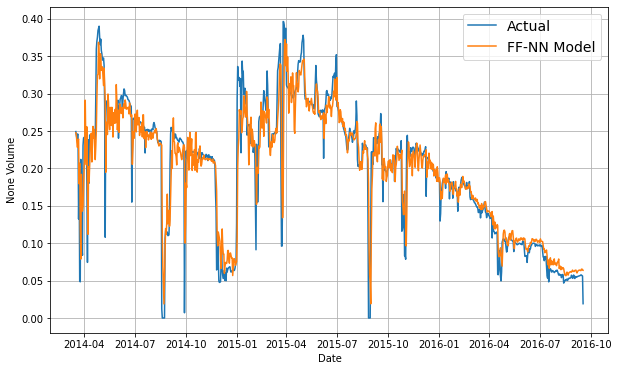

mae = 0.01900336891412735, 
mse = 0.0010764605831354856, 
rmse = 0.032809458744933385


In [61]:
ffnn_oil_forecast = model_forecast(
    
                    model,
                    scaled_oil_data[split_date - window_size:-1],
                    window_size

                                )[:, 0]

plt.figure(figsize=(10, 6))
plot_series(date_valid, oil_valid, label="Actual")
plot_series(date_valid, ffnn_oil_forecast, "Oil", label="FF-NN Model")

plt.show()

mae = keras.metrics.mean_absolute_error(oil_valid, ffnn_oil_forecast).numpy()
mse = keras.metrics.mean_squared_error(oil_valid, ffnn_oil_forecast).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

Gas

In [62]:
refresh()

window_size = 30

gas_train_set = window_dataset(gas_train, window_size)

model = Sequential([
            Dense(10, activation="relu", input_shape=[window_size]),
            Dense(10, activation="relu"),
            Dense(1)
        ])

lr_schedule = LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(gas_train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
71/71 [==============================] - 1s 5ms/step - loss: 0.1247 - mae: 0.4135
Epoch 2/100
71/71 [==============================] - 0s 4ms/step - loss: 0.1071 - mae: 0.3802
Epoch 3/100
71/71 [==============================] - 0s 4ms/step - loss: 0.0900 - mae: 0.3456
Epoch 4/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0742 - mae: 0.3105
Epoch 5/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0599 - mae: 0.2759
Epoch 6/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0477 - mae: 0.2427
Epoch 7/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0374 - mae: 0.2116
Epoch 8/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0292 - mae: 0.1831
Epoch 9/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0229 - mae: 0.1576
Epoch 10/100
71/71 [==============================] - 0s 5ms/step - loss: 0.0182 - mae: 0.1359
Epoch 11/100
71/71 [==============================] - 0s 4m

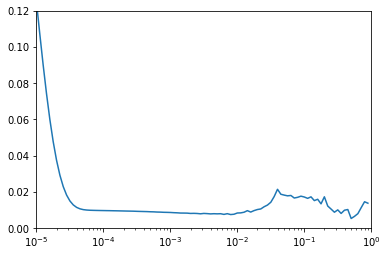

0.8912509

In [63]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1, 0, 0.12])

plt.show()

max(history.history["lr"])

In [64]:
refresh()

window_size = 30

gas_train_set = window_dataset(gas_train, window_size)
gas_valid_set = window_dataset(gas_valid, window_size)

model = Sequential([
            Dense(10, activation="relu", input_shape=[window_size]),
            Dense(10, activation="relu"),
            Dense(1)
        ])

optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = EarlyStopping(patience=10)

model.fit(gas_train_set,
          epochs=500,
          validation_data=gas_valid_set,
          callbacks=[early_stopping])

Epoch 1/500
71/71 [==============================] - 1s 11ms/step - loss: 0.0399 - mae: 0.2001 - val_loss: 0.0031 - val_mae: 0.0639
Epoch 2/500
71/71 [==============================] - 1s 8ms/step - loss: 0.0113 - mae: 0.0969 - val_loss: 0.0019 - val_mae: 0.0434
Epoch 3/500
71/71 [==============================] - 1s 8ms/step - loss: 0.0115 - mae: 0.0998 - val_loss: 0.0019 - val_mae: 0.0428
Epoch 4/500
71/71 [==============================] - 1s 8ms/step - loss: 0.0110 - mae: 0.0956 - val_loss: 0.0018 - val_mae: 0.0405
Epoch 5/500
71/71 [==============================] - 1s 8ms/step - loss: 0.0107 - mae: 0.0937 - val_loss: 0.0017 - val_mae: 0.0392
Epoch 6/500
71/71 [==============================] - 1s 8ms/step - loss: 0.0103 - mae: 0.0912 - val_loss: 0.0016 - val_mae: 0.0378
Epoch 7/500
71/71 [==============================] - 1s 8ms/step - loss: 0.0101 - mae: 0.0893 - val_loss: 0.0015 - val_mae: 0.0364
Epoch 8/500
71/71 [==============================] - 1s 7ms/step - loss: 0.0099 - 

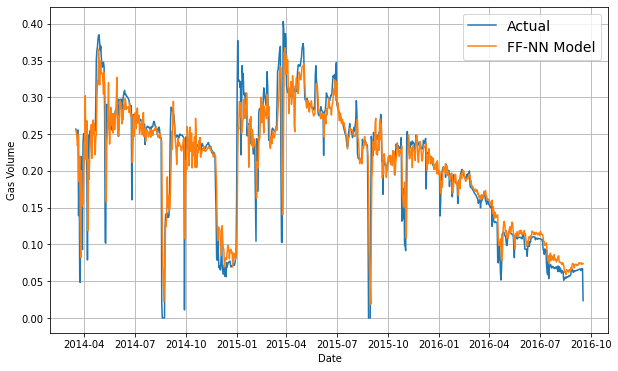

mae = 0.019211512058973312, 
mse = 0.0011159389978274703, 
rmse = 0.033405673138367835


In [65]:
ffnn_gas_forecast = model_forecast(
    
                    model,
                    scaled_gas_data[split_date - window_size:-1],
                    window_size

                                )[:, 0]

plt.figure(figsize=(10, 6))
plot_series(date_valid, gas_valid, label="Actual")
plot_series(date_valid, ffnn_gas_forecast, "Gas", label="FF-NN Model")

plt.show()

mae = keras.metrics.mean_absolute_error(gas_valid, ffnn_gas_forecast).numpy()
mse = keras.metrics.mean_squared_error(gas_valid, ffnn_gas_forecast).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

# RNN Model - LSTM

In [66]:
def sequential_window_dataset(series, window_size):
    
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=window_size, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[1:]))
    
    return dataset.batch(1).prefetch(1)

Oil

In [73]:
refresh()

window_size = 30

oil_train_set = sequential_window_dataset(oil_train, window_size)

model = Sequential([
    
        LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
        LSTM(100, return_sequences=True, stateful=True),
        Dense(1)
    
        ])

learning_rate_schedule = LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)

model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(oil_train_set, epochs=100, callbacks=[learning_rate_schedule, reset_states])

Epoch 1/100
71/71 [==============================] - 9s 30ms/step - loss: 0.1401 - mae: 0.4342
Epoch 2/100
71/71 [==============================] - 1s 21ms/step - loss: 0.1345 - mae: 0.4221
Epoch 3/100
71/71 [==============================] - 2s 34ms/step - loss: 0.1284 - mae: 0.4091
Epoch 4/100
71/71 [==============================] - 1s 20ms/step - loss: 0.1221 - mae: 0.3952
Epoch 5/100
71/71 [==============================] - 2s 27ms/step - loss: 0.1155 - mae: 0.3804: 1s
Epoch 6/100
71/71 [==============================] - 2s 26ms/step - loss: 0.1087 - mae: 0.3648: 3s -
Epoch 7/100
71/71 [==============================] - 2s 22ms/step - loss: 0.1018 - mae: 0.3483
Epoch 8/100
71/71 [==============================] - 2s 35ms/step - loss: 0.0947 - mae: 0.3311: 0s - loss: 0.1028 - mae: 0.
Epoch 9/100
71/71 [==============================] - 3s 46ms/step - loss: 0.0877 - mae: 0.3132: 1s - loss: 0.2012 - mae: 0. - ETA: 0s - loss: 0.166 - ETA: 0s - loss: 0.0998 - ma
Epoch 10/100
71/71 [===

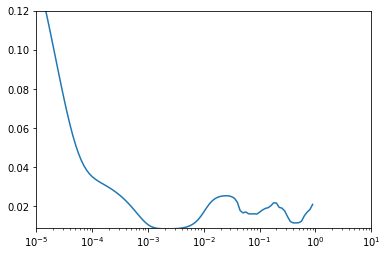

0.8912509

In [74]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 10, 0.009, 0.12])
plt.show()

max(history.history["lr"])

In [75]:
refresh()

window_size = 30
oil_train_set = sequential_window_dataset(oil_train, window_size)
oil_valid_set = sequential_window_dataset(oil_valid, window_size)

model = Sequential([
                    
        LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
        LSTM(100, return_sequences=True, stateful=True),
        Dense(1)
        
        ])

optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

reset_states = ResetStatesCallback()
model_checkpoint = ModelCheckpoint("LSTM_oil_checkpoint.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=50)

model.fit(oil_train_set, epochs=500, validation_data=oil_valid_set, 
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
71/71 [==============================] - 12s 55ms/step - loss: 0.0853 - mae: 0.3288 - val_loss: 0.0072 - val_mae: 0.0985
Epoch 2/500
71/71 [==============================] - 2s 26ms/step - loss: 0.0369 - mae: 0.2263 - val_loss: 0.0053 - val_mae: 0.0825
Epoch 3/500
71/71 [==============================] - 3s 41ms/step - loss: 0.0312 - mae: 0.2057 - val_loss: 0.0042 - val_mae: 0.0725
Epoch 4/500
71/71 [==============================] - 2s 31ms/step - loss: 0.0259 - mae: 0.1851 - val_loss: 0.0033 - val_mae: 0.0627
Epoch 5/500
71/71 [==============================] - 3s 43ms/step - loss: 0.0215 - mae: 0.1657 - val_loss: 0.0025 - val_mae: 0.0539
Epoch 6/500
71/71 [==============================] - 2s 33ms/step - loss: 0.0178 - mae: 0.1477 - val_loss: 0.0020 - val_mae: 0.0466
Epoch 7/500
71/71 [==============================] - 3s 43ms/step - loss: 0.0149 - mae: 0.1312 - val_loss: 0.0016 - val_mae: 0.0407
Epoch 8/500
71/71 [==============================] - 3s 44ms/step - loss: 0

In [76]:
#load best model
model = keras.models.load_model("LSTM_oil_checkpoint.h5")

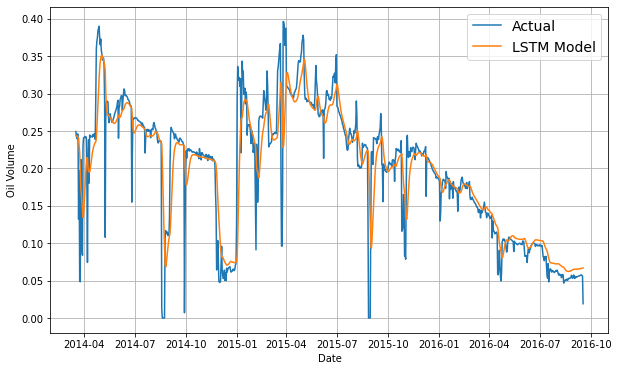

mae = 0.023108717054128647, 
mse = 0.0017336857272312045, 
rmse = 0.04163755188806379


In [77]:
#forecast
LSTM_oil_forecast = model.predict(scaled_oil_data[np.newaxis, :, np.newaxis])
LSTM_oil_forecast = LSTM_oil_forecast[0, split_date - 1:-1, 0]

plt.figure(figsize=(10, 6))
plot_series(date_valid, oil_valid, label="Actual")
plot_series(date_valid, LSTM_oil_forecast, "Oil", label="LSTM Model")

plt.show()

mae = keras.metrics.mean_absolute_error(oil_valid, LSTM_oil_forecast).numpy()
mse = keras.metrics.mean_squared_error(oil_valid, LSTM_oil_forecast).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

Gas

In [78]:
refresh()

window_size = 30

gas_train_set = sequential_window_dataset(gas_train, window_size)

model = Sequential([
    
        LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
        LSTM(100, return_sequences=True, stateful=True),
        Dense(1)
    
        ])

learning_rate_schedule = LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)

model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(gas_train_set, epochs=100, callbacks=[learning_rate_schedule, reset_states])

Epoch 1/100
71/71 [==============================] - 11s 31ms/step - loss: 0.1381 - mae: 0.4387
Epoch 2/100
71/71 [==============================] - 2s 27ms/step - loss: 0.1324 - mae: 0.4265
Epoch 3/100
71/71 [==============================] - 2s 33ms/step - loss: 0.1263 - mae: 0.4134: 1s - loss:
Epoch 4/100
71/71 [==============================] - 2s 31ms/step - loss: 0.1199 - mae: 0.3993: 0s - loss: 0.1329 - mae: 0.
Epoch 5/100
71/71 [==============================] - 2s 34ms/step - loss: 0.1132 - mae: 0.3844
Epoch 6/100
71/71 [==============================] - 3s 43ms/step - loss: 0.1064 - mae: 0.3687
Epoch 7/100
71/71 [==============================] - 3s 40ms/step - loss: 0.0993 - mae: 0.3521
Epoch 8/100
71/71 [==============================] - 2s 26ms/step - loss: 0.0922 - mae: 0.3347: 0s - loss: 0.0972 - mae: 0.34
Epoch 9/100
71/71 [==============================] - 2s 34ms/step - loss: 0.0852 - mae: 0.3165: 0s - loss: 0.1148 - mae: 0 - ETA: 0s - loss: 0.1033 - ma
Epoch 10/100
7

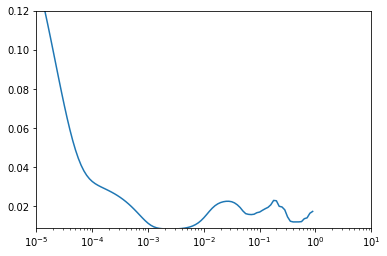

0.8912509

In [79]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 10, 0.009, 0.12])
plt.show()

max(history.history["lr"])

In [80]:
refresh()

window_size = 30
gas_train_set = sequential_window_dataset(gas_train, window_size)
gas_valid_set = sequential_window_dataset(gas_valid, window_size)

model = Sequential([
                    
        LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
        LSTM(100, return_sequences=True, stateful=True),
        Dense(1)
        
        ])

optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

reset_states = ResetStatesCallback()
model_checkpoint = ModelCheckpoint("LSTM_gas_checkpoint.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=50)

model.fit(gas_train_set, epochs=500, validation_data=gas_valid_set, 
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
71/71 [==============================] - 13s 72ms/step - loss: 0.0815 - mae: 0.3177 - val_loss: 0.0071 - val_mae: 0.0974
Epoch 2/500
71/71 [==============================] - 2s 31ms/step - loss: 0.0345 - mae: 0.2175 - val_loss: 0.0054 - val_mae: 0.0825
Epoch 3/500
71/71 [==============================] - 3s 37ms/step - loss: 0.0298 - mae: 0.2001 - val_loss: 0.0044 - val_mae: 0.0738
Epoch 4/500
71/71 [==============================] - 2s 34ms/step - loss: 0.0254 - mae: 0.1826 - val_loss: 0.0035 - val_mae: 0.0651
Epoch 5/500
71/71 [==============================] - 2s 35ms/step - loss: 0.0216 - mae: 0.1661 - val_loss: 0.0028 - val_mae: 0.0571
Epoch 6/500
71/71 [==============================] - 3s 37ms/step - loss: 0.0183 - mae: 0.1505 - val_loss: 0.0022 - val_mae: 0.0500
Epoch 7/500
71/71 [==============================] - 3s 44ms/step - loss: 0.0156 - mae: 0.1360 - val_loss: 0.0018 - val_mae: 0.0440
Epoch 8/500
71/71 [==============================] - 4s 51ms/step - loss: 0

In [81]:
#load best model
model = keras.models.load_model("LSTM_gas_checkpoint.h5")

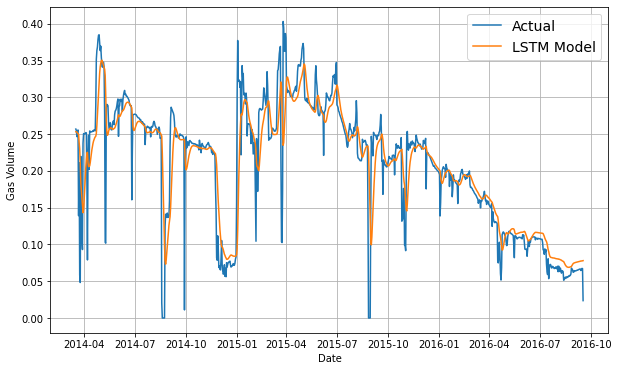

mae = 0.023276330903172493, 
mse = 0.0017854965990409255, 
rmse = 0.042255136954468926


In [82]:
#forecast
LSTM_gas_forecast = model.predict(scaled_gas_data[np.newaxis, :, np.newaxis])
LSTM_gas_forecast = LSTM_gas_forecast[0, split_date - 1:-1, 0]

plt.figure(figsize=(10, 6))
plot_series(date_valid, gas_valid, label="Actual")
plot_series(date_valid, LSTM_gas_forecast, "Gas", label="LSTM Model")

plt.show()

mae = keras.metrics.mean_absolute_error(gas_valid, LSTM_gas_forecast).numpy()
mse = keras.metrics.mean_squared_error(gas_valid, LSTM_gas_forecast).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')